<a href="https://colab.research.google.com/github/sargyri/Drop_Lev/blob/master/Machine_learning/Ps_Volt_conversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Lev Droplet 

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/basic_regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/r2.0rc/site/en/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/r2.0rc/site/en/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

Determination of ST by NN using coords (rho,theta, volume, volt)

In [ ]:
# Use seaborn for pairplot
#!pip install seaborn
#!pip install talos
#!pip install -q  --no-deps tensorflow-addons~=0.7
!pip install lmfit

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib
import pprint
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import seaborn as sns

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.callbacks import ModelCheckpoint

import tensorflow_addons as tfa

print(tf.__version__)


Instructions for updating:
non-resource variables are not supported in the long term
2.3.0


Run the next code box only if google drive is not mounted to colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


If it **is** mounted continue from here on

Check the connection to google's **GPU**

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


**Or** check the connection to google's **TPU**

In [ ]:
if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

### Get the data
First download the dataset!

**Option 1**: Upload files

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import io
csvfilename=str('TritonX100_conci_0.0100_all.csv')
input = pd.read_csv(io.BytesIO(uploaded[csvfilename]))
#input = pd.read_csv(csvfilename, sep="\t")
# Dataset is now stored in a Pandas Dataframe
input.shape

**Option 2**: Import files from drive

In [4]:
#From the drive folder that is mounted to collab go to the file that you are interested in, right click and copy the path of the file. You can find this on the folder symbol on the left:
#OBS! The name of the file and folder(s) must not have a gap! For example a filepath like this: 'This folder/That_file name.csv' won't be able to be readen you should have
#something like: 'This_folder/That_file_name'.

fileWater1=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/water/water__10.50_20200306_alldata_check.csv'), sep="\t")
fileWater2=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/water/water__6.50_20200306_alldata_check.csv'), sep='\t')
fileWater3=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/water/water__8.50_20200306_alldata_check.csv'), sep='\t')
fileWater4=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/water/water__1_20200701_alldata_check.csv'), sep='\t')
fileWater5=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/water/water__2_20200701_alldata_check.csv'), sep='\t')
fileWater6=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/water/water__3_20200701_alldata_check.csv'), sep='\t')


In [5]:
#Add the files one under the other. OBS all the files need to have the same columns! You can add as many files as you want!

input=np.vstack([fileWater1, fileWater2, fileWater3, fileWater4, fileWater5, fileWater6]) 

In [6]:
#Here you give a name to each column! It is much easier to work with dataframes, because you can call each column but the name that you give!
# You can check more if you google about 'pandas dataframe', but in short it is a form of table!

column_names=[]

for i in range(300):
  column_names.append('rho_%d' %i)  #Here one of my parameter is repeated 300 times so I am using a for loop to give the same name to the first 300 columns
for i in range(300):
  column_names.append('phi_%d' %i) 
for i in range(300):
  column_names.append('theta_%d' %i) 
column_names.append('height')
column_names.append('width')  
column_names.append('volume')
column_names.append('R_sph')
column_names.append('volt')
column_names.append('Intensity')
column_names.append('time')
column_names.append('centre_x')
column_names.append('centre_y')
column_names.append('Aspect_Ratio')
column_names.append('Ps')
column_names.append('Ps_err')
column_names.append('Ps_stderr')
column_names.append('dB')
column_names.append('st')

raw_dataset = pd.DataFrame(data=input,  columns=column_names) 
              
raw_dataset.shape  #Prints the shape of the dataset

dataset = raw_dataset.copy()  #Creates a copy of the dataset


#Here we remove the data that we don't want! For that we use the command pop()

for i in range(300):
 dataset.pop('theta_%d' %i)   #Here I can remove the 300 columns of this parameter if I don't it
dataset.pop("height")
dataset.pop("width")
dataset.pop('R_sph')
dataset.pop('Intensity')
dataset.pop('time')
dataset.pop('Ps_err')
dataset.pop('Ps_stderr')
dataset.pop('dB')

dataset.pop("Aspect_Ratio")

dataset.tail()   #The command tail() prints the last 5 rows of the dataset. There is also the command head() that prints the first 5 rows!


,rho_0,rho_1,rho_2,rho_3,rho_4,rho_5,rho_6,rho_7,rho_8,rho_9,rho_10,rho_11,rho_12,rho_13,rho_14,rho_15,rho_16,rho_17,rho_18,rho_19,rho_20,rho_21,rho_22,rho_23,rho_24,rho_25,rho_26,rho_27,rho_28,rho_29,rho_30,rho_31,rho_32,rho_33,rho_34,rho_35,rho_36,rho_37,rho_38,rho_39,...,phi_266,phi_267,phi_268,phi_269,phi_270,phi_271,phi_272,phi_273,phi_274,phi_275,phi_276,phi_277,phi_278,phi_279,phi_280,phi_281,phi_282,phi_283,phi_284,phi_285,phi_286,phi_287,phi_288,phi_289,phi_290,phi_291,phi_292,phi_293,phi_294,phi_295,phi_296,phi_297,phi_298,phi_299,volume,volt,centre_x,centre_y,Ps,st
9458,0.768861,0.768994,0.769090,0.769204,0.769489,0.769850,0.767900,0.768243,0.769384,0.767871,0.768385,0.767099,0.764185,0.762355,0.760770,0.762940,0.760212,0.760222,0.761472,0.760424,0.755734,0.755124,0.753874,0.743537,0.741754,0.737283,0.732555,0.731726,0.730185,0.729473,0.715369,0.708495,0.707658,0.701627,0.703022,0.700082,0.690466,0.688620,0.688216,0.687919,...,2.486384,2.523496,2.530867,2.545549,2.564555,2.579095,2.600725,2.626648,2.633736,2.689505,2.755858,2.760610,2.817425,2.823858,2.835077,2.839920,2.844777,2.862251,2.883110,2.910069,2.930851,2.936812,2.952551,2.957477,3.013510,3.033970,3.038940,3.069219,3.079174,3.094364,3.099329,3.109266,3.119208,3.124181,1.637879,10.86,2.656382,1.594977,2741.229110,72.8
9459,0.773090,0.769411,0.769952,0.771234,0.771547,0.770930,0.767774,0.767507,0.765455,0.767211,0.767240,0.762870,0.763915,0.762391,0.763225,0.762103,0.759305,0.750945,0.747890,0.745313,0.741959,0.743977,0.741614,0.740488,0.727271,0.719607,0.716765,0.711932,0.712466,0.708182,0.700779,0.696980,0.695919,0.694962,0.688405,0.686234,0.686031,0.684270,0.682611,0.679065,...,2.513963,2.528705,2.555052,2.562349,2.624383,2.694073,2.698727,2.758232,2.764881,2.776251,2.782822,2.787595,2.810196,2.826273,2.854971,2.875784,2.880664,2.897834,2.902719,2.959944,2.980563,2.986288,3.016619,3.026525,3.041924,3.056796,3.066733,3.072053,3.101813,3.111751,3.116722,3.121695,3.131643,3.141593,1.642630,10.86,2.633433,1.600714,2753.061660,72.8
9460,0.770831,0.771001,0.771115,0.771248,0.771570,0.768150,0.770147,0.770508,0.767902,0.770280,0.767025,0.766052,0.766892,0.761551,0.763680,0.762223,0.759589,0.759666,0.760936,0.759935,0.754855,0.753750,0.740592,0.738970,0.737841,0.733266,0.732468,0.730988,0.730308,0.716740,0.710096,0.706440,0.703472,0.701869,0.698966,0.692721,0.687677,0.687294,0.687017,0.680276,...,2.495439,2.532379,2.539712,2.554318,2.573252,2.587709,2.606554,2.632469,2.639547,2.697505,2.761561,2.768192,2.824650,2.829473,2.840672,2.845519,2.851831,2.867805,2.888644,2.915549,2.936300,2.942231,2.957017,2.962859,3.018788,3.039195,3.044158,3.074362,3.084299,3.099224,3.104204,3.114304,3.124225,3.129186,1.639032,10.86,2.646820,1.602627,2743.288499,72.8
9461,0.763086,0.763757,0.763929,0.764561,0.762184,0.762530,0.762434,0.759319,0.759435,0.757467,0.759300,0.755804,0.755262,0.756346,0.754913,0.751437,0.752526,0.741697,0.742269,0.739940,0.736909,0.735756,0.733566,0.732528,0.720567,0.714020,0.711824,0.707578,0.705486,0.704573,0.695482,0.692320,0.691474,0.690733,0.685226,0.683366,0.683387,0.682166,0.680598,0.678014,...,2.511424,2.518866,2.533696,2.563114,2.570414,2.697733,2.704652,2.769232,2.780710,2.787333,2.792162,2.810118,2.814972,2.832765,2.860143,2.881154,2.887372,2.903383,2.908320,2.966041,2.986830,2.991827,3.022565,3.033159,3.048194,3.053216,3.063665,3.073687,3.078703,3.109023,3.119040,3.124051,3.129062,3.139086,1.610094,10.86,2.681244,1.633226,2655.702637,72.8
9462,0.761239,0.761306,0.761623,0.762535,0.762774,0.761075,0.757839,0.756873,0.758418,0.756303,0.756061,0.755170,0.756148,0.754472,0.753541,0.750302,0.744134,0.740735,0.741170,0.737320,0.735990,0.736695,0.735463,0.722346,0.714343,0.711315,0.709122,0.706776,0.705274,0.697693,0.693813,0.692727,0.691744,0.688405,0.686234,0.682643,0.680829,0.682611,0.679065,0.675544,...,2.489499,2.519479,2.526930,2.590284,2.661515,2.668578,2.731259,2.736019,2.747600,2.754362,2.759161,2.777384,2.782217,2.827972,2.850627,2.855541,2.87

In [7]:
#Drop 125 values of theta
for i in range(0,125):
  dataset=dataset.drop(dataset.columns[300+i], axis=1)
  i=i+1


#Drop 125 values of rho:
for i in range(0,125):
  dataset=dataset.drop(dataset.columns[i], axis=1)
  i=i+1

# dataset.pop('R_sph')

dataset.tail()

,rho_1,rho_3,rho_5,rho_7,rho_9,rho_11,rho_13,rho_15,rho_17,rho_19,rho_21,rho_23,rho_25,rho_27,rho_29,rho_31,rho_33,rho_35,rho_37,rho_39,rho_41,rho_43,rho_45,rho_47,rho_49,rho_51,rho_53,rho_55,rho_57,rho_59,rho_61,rho_63,rho_65,rho_67,rho_69,rho_71,rho_73,rho_75,rho_77,rho_79,...,phi_266,phi_267,phi_268,phi_269,phi_270,phi_271,phi_272,phi_273,phi_274,phi_275,phi_276,phi_277,phi_278,phi_279,phi_280,phi_281,phi_282,phi_283,phi_284,phi_285,phi_286,phi_287,phi_288,phi_289,phi_290,phi_291,phi_292,phi_293,phi_294,phi_295,phi_296,phi_297,phi_298,phi_299,volume,volt,centre_x,centre_y,Ps,st
9458,0.768994,0.769204,0.769850,0.768243,0.767871,0.767099,0.762355,0.762940,0.760222,0.760424,0.755124,0.743537,0.737283,0.731726,0.729473,0.708495,0.701627,0.700082,0.688620,0.687919,0.679821,0.676532,0.674322,0.669095,0.667015,0.667322,0.666686,0.663783,0.662625,0.661387,0.664157,0.663717,0.660192,0.661664,0.662989,0.662901,0.665280,0.664983,0.664212,0.666104,...,2.486384,2.523496,2.530867,2.545549,2.564555,2.579095,2.600725,2.626648,2.633736,2.689505,2.755858,2.760610,2.817425,2.823858,2.835077,2.839920,2.844777,2.862251,2.883110,2.910069,2.930851,2.936812,2.952551,2.957477,3.013510,3.033970,3.038940,3.069219,3.079174,3.094364,3.099329,3.109266,3.119208,3.124181,1.637879,10.86,2.656382,1.594977,2741.229110,72.8
9459,0.769411,0.771234,0.770930,0.767507,0.767211,0.762870,0.762391,0.762103,0.750945,0.745313,0.743977,0.740488,0.719607,0.711932,0.708182,0.696980,0.694962,0.686234,0.684270,0.679065,0.675133,0.674959,0.674103,0.670010,0.669169,0.667166,0.664793,0.666562,0.664892,0.664188,0.661882,0.663295,0.665354,0.663108,0.667122,0.667253,0.669005,0.668874,0.670610,0.673495,...,2.513963,2.528705,2.555052,2.562349,2.624383,2.694073,2.698727,2.758232,2.764881,2.776251,2.782822,2.787595,2.810196,2.826273,2.854971,2.875784,2.880664,2.897834,2.902719,2.959944,2.980563,2.986288,3.016619,3.026525,3.041924,3.056796,3.066733,3.072053,3.101813,3.111751,3.116722,3.121695,3.131643,3.141593,1.642630,10.86,2.633433,1.600714,2753.061660,72.8
9460,0.771001,0.771248,0.768150,0.770508,0.770280,0.766052,0.761551,0.762223,0.759666,0.759935,0.753750,0.738970,0.733266,0.730988,0.716740,0.706440,0.701869,0.692721,0.687294,0.680276,0.679523,0.678014,0.671728,0.669328,0.669415,0.664347,0.665887,0.663179,0.662119,0.661014,0.664237,0.663753,0.663642,0.660261,0.661589,0.663179,0.661832,0.662385,0.664678,0.665931,...,2.495439,2.532379,2.539712,2.554318,2.573252,2.587709,2.606554,2.632469,2.639547,2.697505,2.761561,2.768192,2.824650,2.829473,2.840672,2.845519,2.851831,2.867805,2.888644,2.915549,2.936300,2.942231,2.957017,2.962859,3.018788,3.039195,3.044158,3.074362,3.084299,3.099224,3.104204,3.114304,3.124225,3.129186,1.639032,10.86,2.646820,1.602627,2743.288499,72.8
9461,0.763757,0.764561,0.762530,0.759319,0.757467,0.755804,0.756346,0.751437,0.741697,0.739940,0.735756,0.732528,0.714020,0.707578,0.704573,0.692320,0.690733,0.683366,0.682166,0.678014,0.674921,0.671728,0.671270,0.668365,0.668124,0.666414,0.664435,0.666985,0.665074,0.663686,0.663841,0.662804,0.664898,0.665601,0.665360,0.665689,0.666590,0.669153,0.670092,0.673076,...,2.511424,2.518866,2.533696,2.563114,2.570414,2.697733,2.704652,2.769232,2.780710,2.787333,2.792162,2.810118,2.814972,2.832765,2.860143,2.881154,2.887372,2.903383,2.908320,2.966041,2.986830,2.991827,3.022565,3.033159,3.048194,3.053216,3.063665,3.073687,3.078703,3.109023,3.119040,3.124051,3.129062,3.139086,1.610094,10.86,2.681244,1.633226,2655.702637,72.8
9462,0.761306,0.762535,0.761075,0.756873,0.756303,0.755170,0.754472,0.750302,0.740735,0.737320,0.736695,0.722346,0.711315,0.706776,0.697693,0.692727,0.688405,0.682643,0.682611,0.675544,0.675133,0.674959,0.670436,0.670010,0.665409,0.667166,0.664793,0.666562,0.662247,0.661805,0.662600,0.663295,0.665277,0.666859,0.667987,0.666233,0.667878,0.670087,0.670239,0.675003,...,2.489499,2.519479,2.526930,2.590284,2.661515,2.668578,2.731259,2.736019,2.747600,2.754362,2.759161,2.777384,2.782217,2.827972,2.850627,2.855541

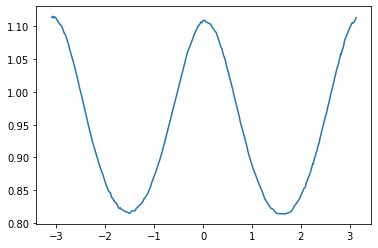

In [8]:
#Check that the drop contour is still well defined!
plt.plot(dataset.iloc[600, 175:350], dataset.iloc[600, 0:175])

### Show the Volume and ST distribution of the data

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will b

Text(0, 0.5, 'Count')

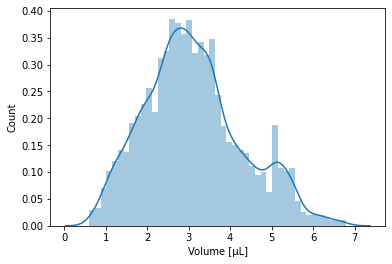

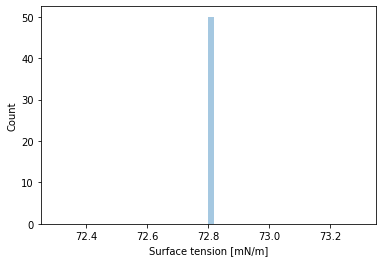

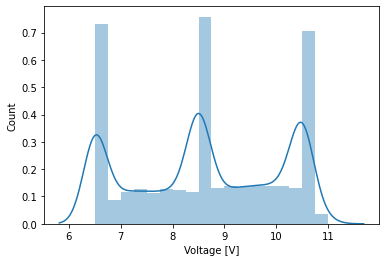

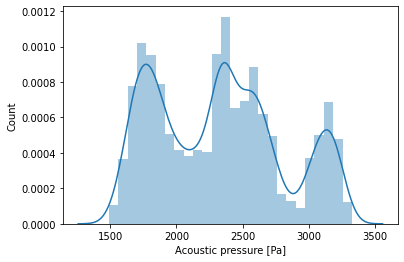

In [45]:
#linex=np.tile(3, 2)
#liney=[0, 0.3]

plt.figure()
sns.distplot(dataset['volume'])
plt.xlabel('Volume [μL]')
plt.ylabel('Count')

plt.figure()
sns.distplot(dataset['st'])
plt.xlabel('Surface tension [mN/m]')
plt.ylabel('Count')

plt.figure()
sns.distplot(dataset['volt'])
plt.xlabel('Voltage [V]')
plt.ylabel('Count')

plt.figure()
sns.distplot(dataset['Ps'])
plt.xlabel('Acoustic pressure [Pa]')
plt.ylabel('Count')


### Selectively choose data with (almost) constant volume

In [ ]:
new_input=[]
vol_min=2.99
vol_max=3.01
for i in range(len(dataset)):
  if dataset['volume'].iloc[i] >= vol_min and dataset['volume'].iloc[i] <= vol_max:
    vol_ct_data=dataset.iloc[i, :]
    new_input.append(vol_ct_data)
new_input=np.asarray(new_input)
new_input.shape

In [ ]:
column_names=[]

for i in range(300):
  column_names.append('rho_%d' %i)
for i in range(300):
  column_names.append('theta_%d' %i)
column_names.append('volume')
column_names.append('R_sph')
column_names.append('volt')
column_names.append('st')

new_dataset=pd.DataFrame(new_input, columns=column_names)
new_dataset.pop('R_sph')
new_dataset.tail()

In [ ]:
plt.figure()
sns.distplot(new_dataset['volt'])
plt.xlabel('Voltage [V]')
plt.ylabel('Count')

plt.figure()
sns.distplot(new_dataset['st'])
plt.xlabel('Surface tension [mN/m]')
plt.ylabel('Count')

### Split the data into train and test

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our model.

In [9]:
dataset.pop('volume')
dataset.pop('centre_x')
dataset.pop('centre_y')
dataset.pop('st')

dataset.tail()

,rho_1,rho_3,rho_5,rho_7,rho_9,rho_11,rho_13,rho_15,rho_17,rho_19,rho_21,rho_23,rho_25,rho_27,rho_29,rho_31,rho_33,rho_35,rho_37,rho_39,rho_41,rho_43,rho_45,rho_47,rho_49,rho_51,rho_53,rho_55,rho_57,rho_59,rho_61,rho_63,rho_65,rho_67,rho_69,rho_71,rho_73,rho_75,rho_77,rho_79,...,phi_262,phi_263,phi_264,phi_265,phi_266,phi_267,phi_268,phi_269,phi_270,phi_271,phi_272,phi_273,phi_274,phi_275,phi_276,phi_277,phi_278,phi_279,phi_280,phi_281,phi_282,phi_283,phi_284,phi_285,phi_286,phi_287,phi_288,phi_289,phi_290,phi_291,phi_292,phi_293,phi_294,phi_295,phi_296,phi_297,phi_298,phi_299,volt,Ps
9458,0.768994,0.769204,0.769850,0.768243,0.767871,0.767099,0.762355,0.762940,0.760222,0.760424,0.755124,0.743537,0.737283,0.731726,0.729473,0.708495,0.701627,0.700082,0.688620,0.687919,0.679821,0.676532,0.674322,0.669095,0.667015,0.667322,0.666686,0.663783,0.662625,0.661387,0.664157,0.663717,0.660192,0.661664,0.662989,0.662901,0.665280,0.664983,0.664212,0.666104,...,2.403959,2.415174,2.430344,2.445480,2.486384,2.523496,2.530867,2.545549,2.564555,2.579095,2.600725,2.626648,2.633736,2.689505,2.755858,2.760610,2.817425,2.823858,2.835077,2.839920,2.844777,2.862251,2.883110,2.910069,2.930851,2.936812,2.952551,2.957477,3.013510,3.033970,3.038940,3.069219,3.079174,3.094364,3.099329,3.109266,3.119208,3.124181,10.86,2741.229110
9459,0.769411,0.771234,0.770930,0.767507,0.767211,0.762870,0.762391,0.762103,0.750945,0.745313,0.743977,0.740488,0.719607,0.711932,0.708182,0.696980,0.694962,0.686234,0.684270,0.679065,0.675133,0.674959,0.674103,0.670010,0.669169,0.667166,0.664793,0.666562,0.664892,0.664188,0.661882,0.663295,0.665354,0.663108,0.667122,0.667253,0.669005,0.668874,0.670610,0.673495,...,2.473524,2.488497,2.491722,2.506566,2.513963,2.528705,2.555052,2.562349,2.624383,2.694073,2.698727,2.758232,2.764881,2.776251,2.782822,2.787595,2.810196,2.826273,2.854971,2.875784,2.880664,2.897834,2.902719,2.959944,2.980563,2.986288,3.016619,3.026525,3.041924,3.056796,3.066733,3.072053,3.101813,3.111751,3.116722,3.121695,3.131643,3.141593,10.86,2753.061660
9460,0.771001,0.771248,0.768150,0.770508,0.770280,0.766052,0.761551,0.762223,0.759666,0.759935,0.753750,0.738970,0.733266,0.730988,0.716740,0.706440,0.701869,0.692721,0.687294,0.680276,0.679523,0.678014,0.671728,0.669328,0.669415,0.664347,0.665887,0.663179,0.662119,0.661014,0.664237,0.663753,0.663642,0.660261,0.661589,0.663179,0.661832,0.662385,0.664678,0.665931,...,2.409376,2.424529,2.439650,2.454734,2.495439,2.532379,2.539712,2.554318,2.573252,2.587709,2.606554,2.632469,2.639547,2.697505,2.761561,2.768192,2.824650,2.829473,2.840672,2.845519,2.851831,2.867805,2.888644,2.915549,2.936300,2.942231,2.957017,2.962859,3.018788,3.039195,3.044158,3.074362,3.084299,3.099224,3.104204,3.114304,3.124225,3.129186,10.86,2743.288499
9461,0.763757,0.764561,0.762530,0.759319,0.757467,0.755804,0.756346,0.751437,0.741697,0.739940,0.735756,0.732528,0.714020,0.707578,0.704573,0.692320,0.690733,0.683366,0.682166,0.678014,0.674921,0.671728,0.671270,0.668365,0.668124,0.666414,0.664435,0.666985,0.665074,0.663686,0.663841,0.662804,0.664898,0.665601,0.665360,0.665689,0.666590,0.669153,0.670092,0.673076,...,2.420989,2.466433,2.481489,2.492231,2.511424,2.518866,2.533696,2.563114,2.570414,2.697733,2.704652,2.769232,2.780710,2.787333,2.792162,2.810118,2.814972,2.832765,2.860143,2.881154,2.887372,2.903383,2.908320,2.966041,2.986830,2.991827,3.022565,3.033159,3.048194,3.053216,3.063665,3.073687,3.078703,3.109023,3.119040,3.124051,3.129062,3.139086,10.86,2655.702637
9462,0.761306,0.762535,0.761075,0.756873,0.756303,0.755170,0.754472,0.750302,0.740735,0.737320,0.736695,0.722346,0.711315,0.706776,0.697693,0.692727,0.688405,0.682643,0.682611,0.675544,0.675133,0.674959,0.670436,0.670010,0.665409,0.667166,0.664793,0.666562,0.662247,0.661805,0.662600,0.663295,0.665277,0.666859,0.667987,0.666233,0.667878,0.670087,0.670239,0.675003,...,2.428863,2.444090,2.451689,2.474415,2.489499,2.519479,2.526930,2.590284,2.661515,2.668578,2.731259,2.736019,2.747600,2.7543

In [10]:
train_dataset = dataset.sample(frac=0.8,random_state=1)
test_dataset = dataset.drop(train_dataset.index)


### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

In [ ]:
#sns.pairplot(train_dataset[column_names], diag_kind="kde")
#plt.show()

Also look at the overall statistics:

In [11]:
train_stats = train_dataset.describe()
train_stats.pop("Ps")   #OBS! I want to predict the surface tension that is why I remove the ST column!

train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
rho_1,7570.0,0.941769,0.137017,0.533626,0.860125,0.942883,1.028601,1.270144
rho_3,7570.0,0.942037,0.137147,0.534681,0.860142,0.942885,1.028803,1.271727
rho_5,7570.0,0.941927,0.137133,0.535392,0.859679,0.942438,1.028478,1.271917
rho_7,7570.0,0.941320,0.137032,0.534708,0.859268,0.941341,1.028813,1.269055
rho_9,7570.0,0.940233,0.136958,0.534462,0.857767,0.939274,1.027708,1.265829
...,...,...,...,...,...,...,...,...
phi_296,7570.0,3.075057,0.031817,2.919888,3.054938,3.081161,3.100489,3.128732
phi_297,7570.0,3.093286,0.026978,2.957467,3.077090,3.100546,3.113938,3.135162
phi_298,7570.0,3.109298,0.023327,3.019504,3.097025,3.116650,3.127010,3.138581
phi_299,7570.0,3.127965,0.014306,3.036716,3.121640,3.132867,3.138482,3.141593


### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [12]:
train_labels = train_dataset.pop('Ps')  #OBS! Same here as in the previous cell
test_labels = test_dataset.pop('Ps') #OBS! Same here

### Normalize the data

Look again at the `train_stats` block above and note how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [13]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)


This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.  That includes the test set as well as live data when the model is used in production.

## The model

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

In [14]:

STEPS_PER_EPOCH=len(train_dataset)/500
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule) #Adam has been working the best as an optimizer in most cases find more options in the next cell!

In [15]:
def build_model():
  model = keras.Sequential([
    layers.Dense(1000, activation=tf.nn.swish, input_shape=[len(train_dataset.keys())]),
    layers.Dense(500, activation=tf.nn.swish),
    # layers.Dense(3, activation=tf.nn.swish),
    layers.Dense(1)
  ])

#Here are differnt optimizer options:

  #optimizer_1 = tf.keras.optimizers.RMSprop(0.0000001)
  #optimizer_2 = tf.keras.optimizers.Adagrad(learning_rate=0.0001)
  #optimizer_3 = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)  
  #optimizer_4 = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.8, beta_2=0.995)

  model.compile(loss='mean_squared_error',
                optimizer=get_optimizer(),  #If you want to try without the learning schedule you should also change the option of the optimizer here! You should put optimizer=optimizer_3 for example!
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [16]:
model = build_model()

## If there is a model saved on google drive execute the next block

In [ ]:
from tensorflow.keras.models import load_model

# del model 
folder=str('theory_experiment_mix/')
model_name=str('All_surf_all_vary_175points_trial_1.h5')
model = load_model(str("/content/drive/My Drive/DropLev/MachineLearningModels/"+folder+model_name))


### Inspect the model

Use the `.summary` method to print a simple description of the model

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              352000    
_________________________________________________________________
dense_1 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 501       
Total params: 853,001
Trainable params: 853,001
Non-trainable params: 0
_________________________________________________________________



Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [18]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


array([[-0.30091557],
       [-0.49498263],
       [-0.49298418],
       [ 0.6989482 ],
       [-0.308387  ],
       [-0.48966986],
       [-0.29545686],
       [ 0.03656934],
       [-0.18991059],
       [ 0.2885363 ]], dtype=float32)

It seems to be working, and it produces a result of the expected shape and type.

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [19]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 55 == 0: print('')
    print('.', end='')


EPOCHS = 5000


early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=75, verbose=0, mode='auto')


history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[early_stop, PrintDot()])  # callbacks=callbacks_list


.......................................................
.......................................................
.......................................................
.......................................................
.......................................................
.......................................................
.......................................................
.......................................................
.......................................................
.......................................................
.......................................................
.......................................................
.......................................................
.......................................................
.......................................................
.......................................................
.......................................................
...............................................

Visualize the model's training progress using the stats stored in the `history` object.

In [20]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
1183,16.932619,3.144009,16.932619,646.165080,14.991938,646.165039,1183
1184,12.805507,2.744704,12.805511,645.519077,14.958520,645.519165,1184
1185,12.265443,2.650538,12.265441,643.816306,15.140341,643.816406,1185
1186,14.123669,2.854166,14.123669,640.218230,14.875966,640.218262,1186
1187,13.689663,2.815813,13.689661,659.411673,15.546966,659.411743,1187


Let's automatically stop training when the validation score doesn't improve. We'll use an *EarlyStopping callback* that tests a training condition for  every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

You can learn more about this callback [here](https://www.tensorflow.org/versions/master/api_docs/python/tf/keras/callbacks/EarlyStopping).

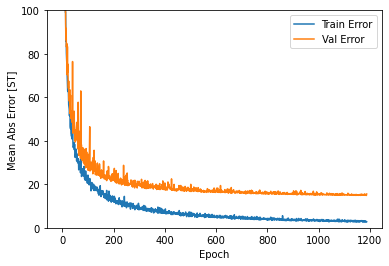

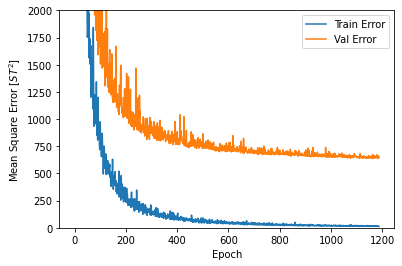

In [21]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [ST]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,100])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$ST^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,2000])
  plt.legend()
  plt.show()


plot_history(history)

Let's see how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

In [22]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
print("Testing set Mean Abs Error: {:5.2f} Pa".format(mae))
# keras.metrics.accuracy(normed_test_data, test_labels)

Testing set Mean Abs Error: 15.11 Pa


### Make predictions

Finally, predict volume values using data in the testing set:

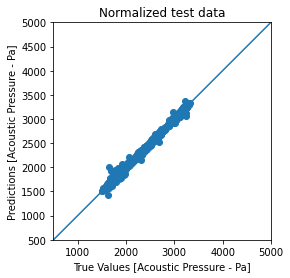

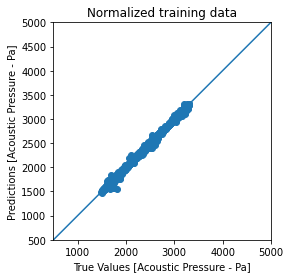

In [23]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.title('Normalized test data')
plt.xlabel('True Values [Acoustic Pressure - Pa]')
plt.ylabel('Predictions [Acoustic Pressure - Pa]')
plt.axis('equal')
plt.axis('square')
plt.xlim([500,5000])
plt.ylim([500,5000])
_ = plt.plot([-5000, 5000], [-5000, 5000])
plt.show()

test_predictions2 = model.predict(normed_train_data).flatten()

plt.scatter(train_labels, test_predictions2)
plt.title('Normalized training data')
plt.xlabel('True Values [Acoustic Pressure - Pa]')
plt.ylabel('Predictions [Acoustic Pressure - Pa]')
plt.axis('equal')
plt.axis('square')
plt.xlim([500,5000])
plt.ylim([500,5000])
_ = plt.plot([-5000, 5000], [-5000, 5000])
plt.show()


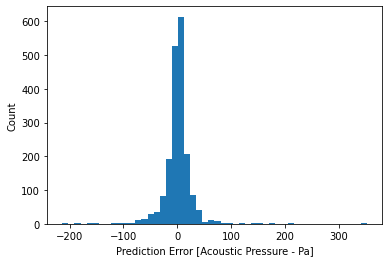

In [24]:
error = test_predictions - test_labels
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [Acoustic Pressure - Pa]")
_ = plt.ylabel("Count")
# plt.xlim(-20, 20)
plt.show()

# Saving the final Model

When you are satisfied with the model and the accuracy continue from here:

Saving the model in a ** HDF5** format

In [ ]:
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
import os

In [70]:
# Save the entire model as a SavedModel.
folder=str('Ps_voltage_conversion/')
filename=str('water_Ps_volt_175points.h5')
!mkdir -p '/content/drive/My Drive/DropLev/MachineLearningModels' #Ceates a folder named "MachineLearningModels"  #OBS! Check the path of your google drive!
model.save('/content/drive/My Drive/DropLev/MachineLearningModels/'+folder+filename)  #Saves the file

# Reload a fresh Keras model from the saved model:

For **SavedModel** format

In [ ]:
#If the folder and the filename are defined from the previous cell then you don't need to define them again!

new_model = tf.keras.models.load_model('/content/drive/My Drive/DropLev/MachineLearningModels/'+folder+filename)

# Check its architecture
new_model.summary()

Evaluate the restored model (for both formats)

In [ ]:
# Evaluation
loss, mae, mse = new_model.evaluate(normed_test_data, test_labels, verbose=0)
print('Restored model, Mean absolute error: {:5.2f}'.format(mae))

print(new_model.predict(normed_test_data).shape)